<a href="https://colab.research.google.com/github/Foong-Ann/Traffic-Sign-Recognition/blob/main/Traffic_Sign_Recognition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Recognition Project

In [ ]:
# link to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Import packages
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim  #for gradient descent
from torchvision import datasets, transforms
import os
import csv
import shutil
import PIL
from sklearn import metrics

#Part 0. Helper Functions


In [ ]:
# For splitting the test data into a format that method ImageFolder can process   
def createClassFolders(target_directory):
    # Check whether the target directory already exists
    if not os.path.exists(target_directory):
        os.mkdir(target_directory)
    else:
        print("Directory Exists")
        return
    
    for c in range (0,43):
        if not os.path.exists(target_directory + '/' + format(c, '05d')):
          os.mkdir(target_directory + '/' + format(c, '05d'))
        else:
          return
    print("Data is splitted")

def splitTestClasses(data_directory, target_directory, csv_name):
    csvFile = open(data_directory + '/'+ csv_name +'.csv') # annotations file
    csvReader = csv.reader(csvFile, delimiter=';')
    next(csvReader) # skip the headers
    i = 0
    for row in csvReader:
        while i < 1800:
          shutil.copy(data_directory + '/' + row[0], target_directory + '/' + format(int(row[7]), '05d') + '/')
          if (i/100 == 0):
            print('{}image copied'.format(i+1))
          i+=1
    print("splitting completed")

def plotClassDistribution(dataset):
    data_number = np.zeros(43)
    labels = []
    for label in dataset.targets:
        data_number[label] += 1
    plt.title("Number of Images in Each Class")
    plt.bar(range(0,43), data_number)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()
    return data_number

def plotTrainClassDistribution(dataset):
    ''' Specifically used for visualizing class distribution after data processing
    '''  
    dataloader =  torch.utils.data.DataLoader(dataset, batch_size = 512, sampler = sampler)
    data_number = np.zeros(43)
    for data, labels in dataloader:
        for class_num in labels:
            data_number[class_num] += 1
    plt.title("Number of Images in Each Class")
    plt.bar(range(0,43), data_number)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()

# Getting model name for saving the model later
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/drive/My Drive/APS360 Project/Models/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_trained_model(modelclass, model_name, batch_size, learning_rate, epoch, use_cuda=True):
    model_for_test = modelclass()
    model_for_test.load_state_dict(torch.load(get_model_name(model_name, batch_size, learning_rate, epoch)))

    if torch.cuda.is_available() and use_cuda==True:
      model_for_test.cuda()

    model_for_test.eval()
    return model_for_test

## Part 1. Data Processing

### 1.1 Data Processing for Traffic Sign Recognition

In [ ]:
# Set the dataset directory
dataset_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images"
splitted_train_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Training_Images/Splitted_Images"
raw_test_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images"
classfied_test_dir =  "/content/drive/My Drive/APS360 Project/Recognition_Data_Set/test"

In [ ]:
# # Unzip the datasets to the google drive folder
# # # Set current working directory
# zip_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Training_Images.zip"
# target_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Training_Images"
# # zip_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Test_Images.zip"
# # target_dir = "/content/drive/My Drive/APS360 Project/GTSRB_Final_Test_Images"
# # # load zip file data
# import shutil
# shutil.unpack_archive(zip_dir, target_dir, "zip")

In [ ]:
# test_csv_name = "GT-final_test"
# createClassFolders(classfied_test_dir)
# splitTestClasses(raw_test_dir, classfied_test_dir, test_csv_name)

Data is already splited into 43 classes
splitting completed


In [ ]:
# !pip install split-folders
# import split_folders
# split_folders.ratio(dataset_dir, output = splitted_train_dir, ratio = (0.8, 0.2))

Copying files: 39252 files [1:22:47,  7.90 files/s]


In [ ]:
# !pip install split-folders
# import split_folders
# final_dir = "/content/drive/My Drive/APS360 Project/Recognition_Data_Set"
# split_folders.ratio(splitted_train_dir +"/val", output = final_dir, ratio = (0.8, 0.2))

Copying files: 7884 files [1:01:36,  2.13 files/s]


Data augmentation and resizing

In [ ]:
# Transform the data for later use and load the data into dataloader for displaying some sample image and testing out dataloaders
transformations = transforms.Compose([ 
                                      transforms.RandomApply([
                                                              transforms.RandomGrayscale(p=0.1), 
                                                              transforms.RandomRotation(10, resample = PIL.Image.BICUBIC),
                                                              transforms.RandomResizedCrop(224,scale=(0.5, 1.0)),
                                                              transforms.RandomAffine(10)

                                      ]),
                                      transforms.Resize((224,224)), 
                                      transforms.ToTensor()
])

In [ ]:
# Load training and validation data into data loader for testing
final_dir = "/content/drive/My Drive/APS360 Project/Recognition_Data_Set"
recognition_train_data = datasets.ImageFolder(final_dir + "/train", transform=transformations)
recognition_val_data = datasets.ImageFolder(final_dir + "/val", transform=transformations)
recognition_test_data = datasets.ImageFolder(final_dir + "/test", transform = transformations)


Obtain a subset of 512 images from the training data for sanity checks



In [ ]:
recognition_small_data, other = torch.utils.data.dataset.random_split(recognition_train_data, (512, len(recognition_train_data)-512))

In [ ]:
# # Load test data into data loader for testing
# recognition_test_data = datasets.ImageFolder(classfied_test_dir, transform = transformations)
# recognition_test_loader = torch.utils.data.DataLoader(recognition_test_data, batch_size=256, shuffle=True)

In [ ]:
classes_names = ['speed limit 20', 'speed limit 30', 'speed limit 50', 'speed limit 60', 'speed limit 70', 
                 'speed limit 80', 'restriction ends 80', 'speed limit 100', 'speed limit 120', 'no overtaking', 
                 'no overtaking (trucks)', 'priority at next intersection', 'priority road', 'give way', 'stop', 'no traffic both ways',
                 'no trucks', 'no entry', 'danger', 'bend left', 'bend right', 'bend', 'uneven road', 'slippery road',
                 'road narrows', 'construction', 'traffic signal', 'pedestrian crossing', 'school crossing', 'cycles crossing',
                 'snow', 'animals', 'restriction ends', 'go right', 'go left', 'go straight', 'go right or straight', 
                 'go left or straight', 'keep right', 'keep left', 'roundabout', 'restriction ends (overtaking)', 
                 'restriction ends (overtaking (trucks))']

In [ ]:
# Visualize 20 sample images
def visualizeSampleImage(data_loader):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes_names[int(labels[idx])])

Images from training data


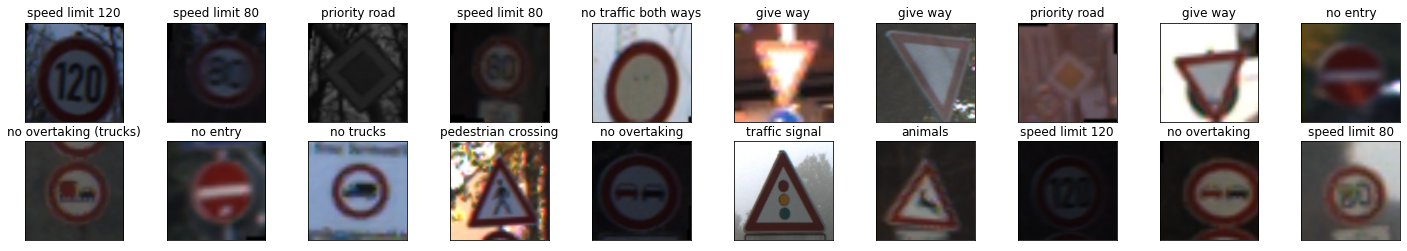

In [ ]:
recognition_loader_view_images = torch.utils.data.DataLoader(recognition_train_data, batch_size=256, shuffle=True)
visualizeSampleImage(recognition_loader_view_images)

Images from testing data

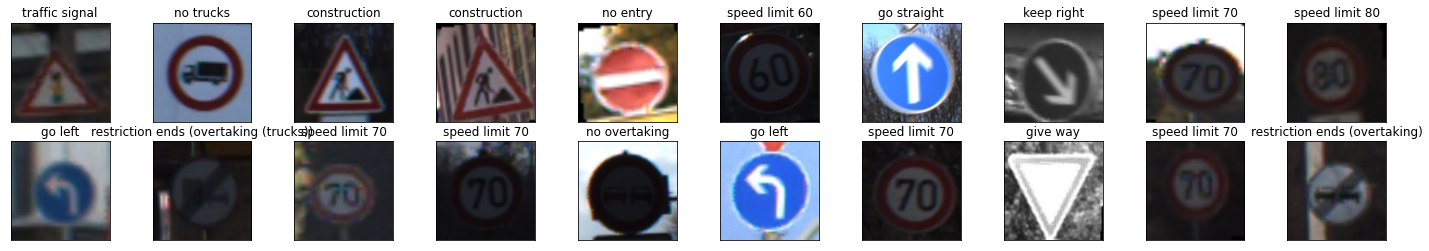

In [ ]:
recognition_loader_view_test_images = torch.utils.data.DataLoader(recognition_test_data, batch_size=256, shuffle=True)
visualizeSampleImage(recognition_loader_view_test_images)

#Visualise class distribution
Dataset is unbalanced

There are 39209 in the dataset, excluding the testing data


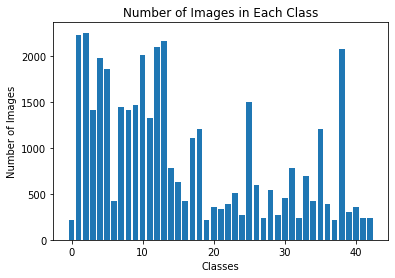

In [ ]:
# The code in the following section is modified based on the sample code for loading the data provided by the dataset website:

# The original code that the above code is based on the German Traffic Sign Recognition Benchmark
total_data_set_size = 0
classes = []
num_of_image_in_class = []
for c in range(0,43):
    prefix = dataset_dir + '/' + format(c, '05d') + '/'
    gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
    gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
    next(gtReader) # skip header
    # loop over all images in current annotations file
    num_of_img = 0
    for row in gtReader:
        # each row represents the information of one image, so we count the total number of images in each class
        num_of_img += 1
    gtFile.close() # close the file
    classes.append(format(c, '05d'))
    total_data_set_size += num_of_img
    num_of_image_in_class.append(num_of_img)

print ("There are {} in the dataset, excluding the testing data".format(total_data_set_size))
# Plot the number of images in each of the 42 classes
plt.title("Number of Images in Each Class")
plt.bar(range(0,43), num_of_image_in_class)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

# From graph below, notice disparity of number of images across classes. Hence, data augmentation is needed to create a balanced dataset.

#Splitting datasets into train & validation data 

Before balancing the data for each class, we must first split the dataset into training and validation data to avoid overestimating the accuracy and keep it true to the real-life situation

In [ ]:
# total_data_set_size = len(Recognition_data)
# train_data_size = int(total_data_set_size*0.8)
# torch.manual_seed(1)  #Random seed for reproductivity
# recognition_train_data, recognition_val_data = torch.utils.data.random_split(Recognition_data, [train_data_size, total_data_set_size-train_data_size])

# print("There are {} images for training".format(len(recognition_train_data)))
# print("There are {} images for validation".format(len(recognition_val_data)))

In [ ]:
print("There are {} images for training".format(len(recognition_train_data)))
print("There are {} images for validation".format(len(recognition_val_data)))
print("There are {} images for test".format(len(recognition_test_data)))

There are 6281 images for training
There are 1509 images for validation
There are 1800 images for test


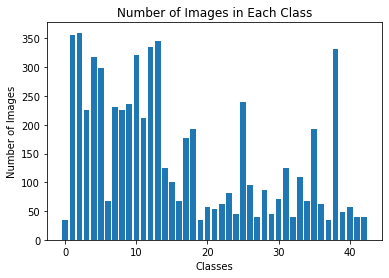

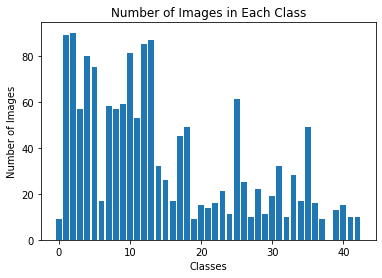

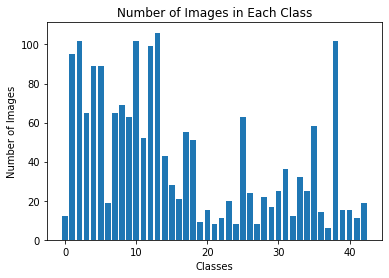

In [ ]:
recognition_train_class_number = plotClassDistribution(recognition_train_data)
recognition_val_class_number = plotClassDistribution(recognition_val_data)
recognition_test_class_number = plotClassDistribution(recognition_test_data)

Use WeightedRandomSampler to balance the dataset

In [ ]:
# get the sampler for the training data to obtain a balanced dataset 
class_count = range(0,43)
weights = 1 / np.array([recognition_train_class_number[n] for n in class_count])
train_samples_weights = [weights[labels] for labels in recognition_train_data.targets]
sampler = torch.utils.data.WeightedRandomSampler(train_samples_weights, 43*150)

Class distribution after balancing dataset

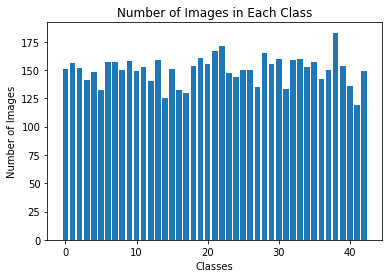

In [ ]:
# now we see whether the distribution of data is roughly balanced
plotTrainClassDistribution(recognition_train_data)

## Part 2. Baseline Model

###  2.1 baseline model for traffic sign recognition

AvgPool and tanh used to make model have worst-case accuracy for CNN

In [ ]:
# The baseline model for traffic sign recognition:
class SimpleCNNModel(nn.Module):
    def __init__(self, name="SimpleCNNModel"):
        super(SimpleCNNModel, self).__init__()
        self.name = name
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(60500, 43)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = x.view(-1, 60500)
        x = self.fc1(x)
        return x

In [ ]:
def get_accuracy (model, dataloader):
    correct = 0
    total = 0
    for imgs, labels in dataloader:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train (model, train_data, val_data, batch_size=256, num_epoch=20, learning_rate=1e-4):
    if train_data == recognition_small_data:
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    else:
        train_loader = torch.utils.data.DataLoader(train_data, sampler=sampler, batch_size = batch_size)

    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    torch.manual_seed(1000)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_losses, train_acc, val_losses, val_acc = [], [], [], [], []

    start_time = time.time()
    print("Start Training the model ...")
    
    for n in range (num_epoch):
        epoch_start_time = time.time()
        
        total_train_loss = 0
        num_of_train_batches = 0
        
        for imgs, labels in train_loader:
            model.train()
            num_of_train_batches += 1
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)       # forward pass
            loss = criterion (out, labels) #Compute the total loss
            loss.backward()         # backward pass
            optimizer.step()        # update the parameters
            optimizer.zero_grad()   # a clean up step for PyTorch
            total_train_loss += (loss.item()/batch_size)

        total_val_loss = 0
        num_of_val_batches = 0
        for imgs, labels in val_loader:
            model.eval()
            num_of_val_batches += 1
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            val_out = model(imgs)
            val_loss = criterion (val_out, labels)
            total_val_loss += (val_loss.item()/batch_size)

        train_losses.append(float(total_train_loss/num_of_train_batches))             # compute *average* loss
        val_losses.append(float(total_val_loss/num_of_val_batches))             # compute *average* loss
        
        
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        
        iters.append(n)
        # Print the result at current epoch
        print(("Epoch {}: Train accuracy: {}, Train loss: {} | " +
                "Validation accuracy: {}, Validation loss: {} | time: {} s").format(n+1, train_acc[-1], train_losses[-1], val_acc[-1], val_losses[-1], epoch_time))
        
        # Save model to drive
        model_path =  get_model_name(model.name, batch_size, learning_rate, n+1)
        torch.save(model.state_dict(), model_path)


    # plotting
    plt.title("Training and Validation Losses")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training and Validation Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    end_time = time.time()
    total_time = end_time - start_time
    print("Training Completed")
    print('Total time = {} s'.format(total_time))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Tuning hyperparameters, model not chosen

Training on GPU ...
Start Training the model ...
Epoch 1: Train accuracy: 0.10546875, Train loss: 0.007332915905863047 | Validation accuracy: 0.0892742453436095, Validation loss: 0.008722743601538241 | time: 11.788029432296753 s
Epoch 2: Train accuracy: 0.0625, Train loss: 0.008716421201825142 | Validation accuracy: 0.057161207450224794, Validation loss: 0.009140413254499435 | time: 10.850384950637817 s
Epoch 3: Train accuracy: 0.103515625, Train loss: 0.008654952980577946 | Validation accuracy: 0.09377007064868337, Validation loss: 0.008074286975897849 | time: 10.999881267547607 s
Epoch 4: Train accuracy: 0.125, Train loss: 0.007233860902488232 | Validation accuracy: 0.09762363519588953, Validation loss: 0.0075587035389617085 | time: 10.851083517074585 s
Epoch 5: Train accuracy: 0.20703125, Train loss: 0.006765047553926706 | Validation accuracy: 0.13102119460500963, Validation loss: 0.007541831932030618 | time: 10.894271850585938 s
Epoch 6: Train accuracy: 0.29296875, Train loss: 0.00

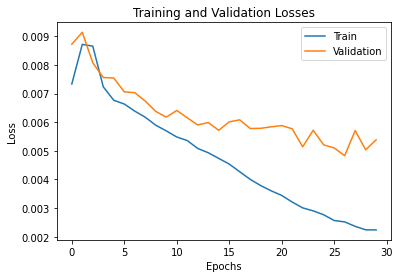

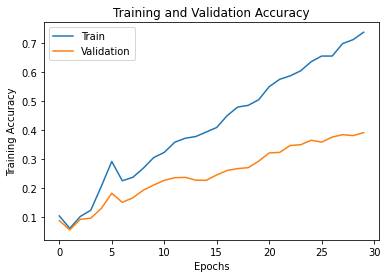

Training Completed
Total time = 331.5903980731964 s
Final Training Accuracy: 0.73828125
Final Validation Accuracy: 0.3924213230571612


In [ ]:
use_cuda = True
BaselineModelsub = SimpleCNNModel()

if torch.cuda.is_available():
  BaselineModelsub.cuda()
  print('Training on GPU ...')
else:
  print('Training on CPU ...')

train(BaselineModelsub, recognition_small_data, recognition_val_data, batch_size = 512, num_epoch = 30, learning_rate=0.001)

# Chosen baseline model & validation accuracy

Training on GPU ...
Start Training the model ...
Epoch 1: Train accuracy: 0.25720930232558137, Train loss: 0.021734680872983657 | Validation accuracy: 0.21733668341708542, Validation loss: 0.011689947918057442 | time: 51.12582731246948 s
Epoch 2: Train accuracy: 0.5251162790697674, Train loss: 0.009147981880232692 | Validation accuracy: 0.4265075376884422, Validation loss: 0.008803780722830976 | time: 190.91317629814148 s
Epoch 3: Train accuracy: 0.5992248062015504, Train loss: 0.00676089426717506 | Validation accuracy: 0.4956030150753769, Validation loss: 0.007442642335913011 | time: 94.33362746238708 s
Epoch 4: Train accuracy: 0.6663565891472868, Train loss: 0.005610127951233433 | Validation accuracy: 0.5728643216080402, Validation loss: 0.0064919922899987015 | time: 70.94507479667664 s
Epoch 5: Train accuracy: 0.6885271317829458, Train loss: 0.005229549213814048 | Validation accuracy: 0.5778894472361809, Validation loss: 0.00634612242824265 | time: 57.69002079963684 s
Epoch 6: Train

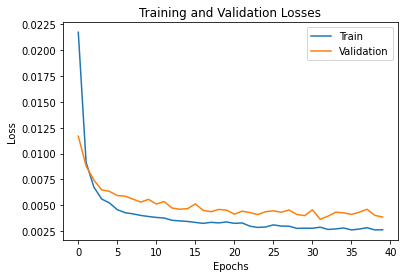

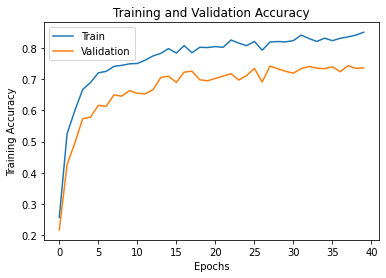

Training Completed
Total time = 2289.238644361496 s
Final Training Accuracy: 0.8493023255813954
Final Validation Accuracy: 0.7355527638190955


In [ ]:
use_cuda = True
BaselineModel = SimpleCNNModel()

if torch.cuda.is_available():
  BaselineModel.cuda()
  print('Training on GPU ...')
else:
  print('Training on CPU ...')

train(BaselineModel, recognition_train_data, recognition_val_data, batch_size = 256, num_epoch = 40, learning_rate=0.001)

# Chosen baseline model and test accuracy


In [ ]:
use_cuda = True

recognition_test_loader = torch.utils.data.DataLoader(recognition_test_data, batch_size=256, shuffle=True)

trained_baseline_model = get_trained_model(SimpleCNNModel, "SimpleCNNModel", 256, 0.001, 40)

baseline_test_accuracy = get_accuracy(trained_baseline_model, recognition_test_loader)
print("The final accuracy for baseline model is {}".format(baseline_test_accuracy))

The final accuracy for baseline model is 0.5983333333333334


Get accuracy by class


In [ ]:
def pred_vgg (model, data_loader):
    prediction_lst = []
    ground_lst = []

    model.eval()
    for imgs, labels in data_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        for pre in pred:
          prediction_lst.append(pre.item())
        for label in labels:
          ground_lst.append(label.item())

    return prediction_lst, ground_lst

In [ ]:
recognition_val_loader = torch.utils.data.DataLoader(recognition_val_data, batch_size=256, shuffle=True)
baseline_pred, baseline_gt = pred_vgg(trained_baseline_model,recognition_val_loader)

In [ ]:
def getAccuracyByClass(vgg_ground_lst, vgg_prediction_lst, recognition_class_number):
    incorrectly_classified_images = []
    incorrectly_classified_labels = []
    incorrectly_classified_predictions = []

    accuracy_by_class = np.zeros(43)
    for i in range(len(vgg_prediction_lst)):
      if vgg_prediction_lst[i] == vgg_ground_lst[i]:
        accuracy_by_class[vgg_ground_lst[i]] = accuracy_by_class[vgg_ground_lst[i]]+1
    accuracy_by_class = list(accuracy_by_class)
    for i in range(len(accuracy_by_class)):
      accuracy_by_class[i] = accuracy_by_class[i]/recognition_class_number[i]
    return accuracy_by_class

In [ ]:
Baseline_array = getAccuracyByClass(baseline_gt, baseline_pred, recognition_val_class_number)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Baseline validation accuracy for each class

In [ ]:
Baseline_array

[0.3333333333333333,
 0.5280898876404494,
 0.3888888888888889,
 0.6140350877192983,
 0.4375,
 0.37333333333333335,
 0.5882352941176471,
 0.3793103448275862,
 0.42105263157894735,
 0.6949152542372882,
 0.7654320987654321,
 0.5094339622641509,
 0.8705882352941177,
 0.8275862068965517,
 0.6875,
 0.6538461538461539,
 0.8823529411764706,
 0.7777777777777778,
 0.6530612244897959,
 0.3333333333333333,
 0.8,
 0.7857142857142857,
 0.625,
 0.5714285714285714,
 0.5454545454545454,
 0.7049180327868853,
 0.88,
 0.3,
 0.7272727272727273,
 0.45454545454545453,
 0.7368421052631579,
 0.625,
 1.0,
 0.75,
 0.5882352941176471,
 0.8163265306122449,
 0.75,
 0.5555555555555556,
 nan,
 0.9230769230769231,
 0.9333333333333333,
 0.6,
 0.5]

Minimum baseline validation accuracy 


In [ ]:
Baseline_array.index(min(Baseline_array))

27

#Visualising the correct label and incorrect prediction

To identify trends and similarities in commonly mislabeled images

In [ ]:
test_pred = []
test_labels = []
predicted_wrong_img = []
predicted_wrong_gt = []
predicted_wrong_pred = []
for imgs, labels in recognition_test_loader:
    trained_baseline_model.eval()
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    test_labels.append(labels)
    output = trained_baseline_model(imgs)
    pred = output.max(1, keepdim=True)[1]
    prediction = torch.zeros(len(labels))
    for i in range(len(labels)):
        line = pred [i]
        if line != labels [i]:
          predicted_wrong_img.append(imgs[i])
          predicted_wrong_gt.append(labels[i].item())
          predicted_wrong_pred.append(line.item())
        prediction[i] = line[0].item()

    test_pred.append(prediction)

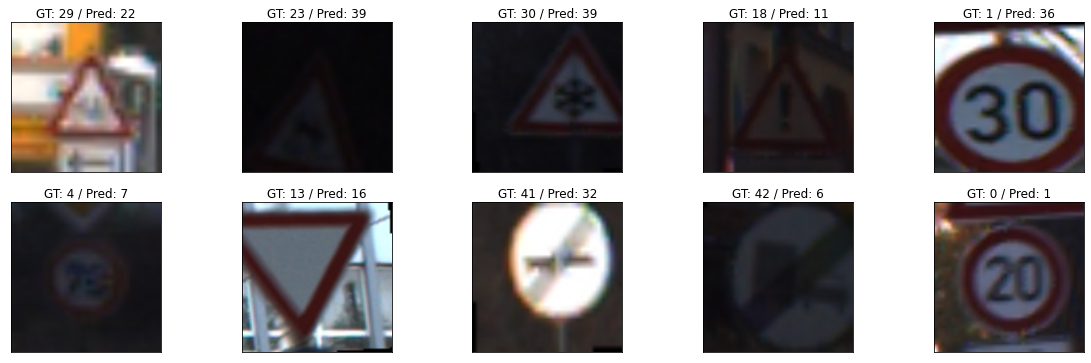

In [ ]:
fig = plt.figure(figsize=(20, 16))
for idx in np.arange(10):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(predicted_wrong_img[idx].cpu(), (1, 2, 0)))
    ax.set_title('GT: {} / Pred: {}'. format(int(predicted_wrong_gt[idx]), int(predicted_wrong_pred[idx])))

In [ ]:
# The following code is based on helper functions from
# https://www.reddit.com/r/pytorch/comments/fazhvs/beginner_pytorch_trying_to_plot_a_confusion_matrix/

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='None', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
          # xticks=np.arange(cm.shape[1]),
          # yticks=np.arange(cm.shape[0]),
          # ... and label them with the respective list entries
          # xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label', xlabel='Predicted label')
    # # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")
    # # Loop over data dimensions and create text annotations.
    # fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    # for i in range(cm.shape[0]):
    #     for j in range(cm.shape[1]):
    #         ax.text(j, i, format(cm[i, j], fmt),
    #                 ha="center", va="center",
    #                 color="white" if cm[i, j] > thresh else "black")
    # fig.tight_layout()
    # return ax

Confusion matrix for val data using baseline model

Normalized confusion matrix


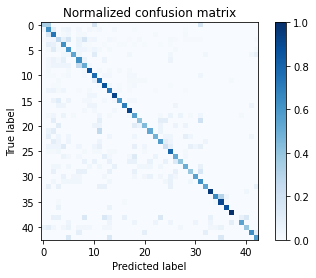

In [ ]:
plot_confusion_matrix(baseline_pred, baseline_gt, classes=range(43), normalize = True, title='Normalized confusion matrix')

Keep track of model predictions on test data and actual labels

In [ ]:
coordinates = []
test_pred_new = []
test_label_new = []
for i in range(7):
  for j in range(256):
    coord = [int(test_pred[i][j].item()),test_labels[i][j].item()]
    test_pred_new.append(int(test_pred[i][j].item()))
    test_label_new.append(test_labels[i][j].item())
    coordinates.append(coord)
for k in range(len(test_pred[7])):
    coord = [int(test_pred[7][k].item()),test_labels[7][k].item()]
    test_pred_new.append(int(test_pred[7][k].item()))
    test_label_new.append(test_labels[7][k].item())
    coordinates.append(coord)

 Calculate test accuracy by class

In [ ]:
class_accuracy = np.zeros(43)
for idx in range(len(test_label_new)):
    if test_pred_new[idx] == test_label_new[idx]:
      class_accuracy[test_label_new[idx]] = class_accuracy[test_label_new[idx]]+1

for i in range(43):
    class_accuracy[i] = class_accuracy[i]/recognition_test_class_number[i]

In [ ]:
class_accuracy

array([0.08333333, 0.61052632, 0.43137255, 0.49230769, 0.3258427 ,
       0.41573034, 0.57894737, 0.47692308, 0.43478261, 0.47619048,
       0.75490196, 0.48076923, 0.75757576, 0.83018868, 0.81395349,
       0.75      , 0.80952381, 0.63636364, 0.41176471, 0.        ,
       0.6       , 0.375     , 0.45454545, 0.25      , 0.5       ,
       0.53968254, 0.70833333, 0.375     , 0.45454545, 0.41176471,
       0.28      , 0.55555556, 0.41666667, 0.96875   , 0.96      ,
       0.63793103, 0.5       , 0.83333333, 0.8627451 , 1.        ,
       0.8       , 0.36363636, 0.63157895])

Identify classes with <50% accuracy

In [ ]:
class_accuracy_lst = class_accuracy.tolist()
lst = []
for acc in class_accuracy_lst:
  if acc < 0.5:
    lst.append(class_accuracy_lst.index(acc))

In [ ]:
lst

[0, 2, 3, 4, 5, 7, 8, 9, 11, 18, 19, 21, 22, 23, 21, 22, 18, 30, 32, 41]

Identify class with min accuracy

In [ ]:
print(classes_names[class_accuracy.tolist().index(min(class_accuracy))])
print(min(class_accuracy))

bend left
0.0


Confusion matrix for test data using baseline model

Normalized confusion matrix


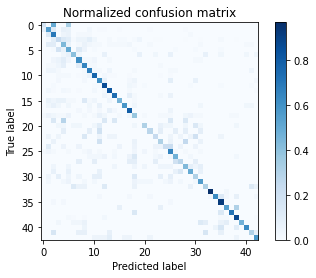

In [ ]:
plot_confusion_matrix(test_pred_new, test_label_new, classes=range(43), normalize = True, title='Normalized confusion matrix')

###  2.2 baseline model for traffic sign detection (attempted)

---



In [ ]:
# The baseline model for traffic sign detection


faces_rects = haar_cascade_face.detectMultiScale(test_image_gray, scaleFactor = 1.2, minNeighbors = 5);

# Let us print the no. of faces found
print('Faces found: ', len(faces_rects))

for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
Finally, we shall display the original image in coloured to see if the face has been detected correctly or not.

In [7]:
#convert image to RGB and show image
plt.imshow(convertToRGB(test_image))

## Part 3. Primary Model

Set up VGG-19 network


In [ ]:
import torchvision.models 
torch.manual_seed(1) # set the random seed
vgg19 = torchvision.models.vgg19_bn(pretrained=True) 

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
# loader1 = torch.utils.data.DataLoader(rec_small_data_vgg, batch_size = 256, shuffle = True, num_workers=0)
# loader2 = torch.utils.data.DataLoader(rec_val_data_vgg, batch_size = 256, shuffle = True, num_workers=0)

# loaderiter1 = iter(loader1)
# loaderiter2 = iter(loader2)

# # obtain one batch of training images
# images1, labels1 = loaderiter1.next()
# images2, labels2 = loaderiter2.next()

# # confirm output from AlexNet feature extraction
# print(images1.shape)

# print(images2.shape)

torch.Size([256, 512, 3, 3])
torch.Size([256, 512, 7, 7])


In [ ]:
# save features to folder as tensors
def save_features (data_loader, dataset_name, model, master_dir, classes):
    n = 0
    for img, label in data_loader:
      features = model.features(img)
      features_tensor = torch.from_numpy(features.detach().numpy())

      folder_name = master_dir + '/' + dataset_name + '/' + str(classes[label])
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
      n += 1

In [ ]:
# save_feature_train_loader =  torch.utils.data.DataLoader(recognition_train_data, batch_size = 1, shuffle=True)
# save_feature_val_loader = torch.utils.data.DataLoader(recognition_val_data, batch_size=1, shuffle=True)
# save_feature_test_loader = torch.utils.data.DataLoader(recognition_test_data, batch_size=1, shuffle=True)
# save_feature_small_loader = torch.utils.data.DataLoader(recognition_small_data, batch_size=1, shuffle=True)

In [ ]:
master_dir = "/content/drive/My Drive/APS360 Project/VGG19_Feature"
classes = []
for i in range (43):
    classes.append(format(i, '05d'))

# save_features (save_feature_train_loader, "feature_train", vgg19, master_dir, classes)
# save_features (save_feature_val_loader, "feature_val", vgg19, master_dir, classes)
# save_features (save_feature_test_loader, "feature_test", vgg19, master_dir, classes)

In [ ]:
# save_features (save_feature_small_loader, "feature_small", vgg19, master_dir, classes)

In [ ]:
rec_train_data_vgg = datasets.DatasetFolder(os.path.join(master_dir, 'feature_train/'), loader=torch.load, extensions=('.tensor'))
rec_val_data_vgg = datasets.DatasetFolder(os.path.join(master_dir, 'feature_val/'), loader=torch.load, extensions=('.tensor'))
rec_test_data_vgg = datasets.DatasetFolder(os.path.join(master_dir, 'feature_test/'), loader=torch.load, extensions=('.tensor'))

ANN Classifier

In [ ]:
#Artificial Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self, name="TransferLearning"):
        super(ANNClassifier, self).__init__()
        self.name = name
        self.fc1 = nn.Linear(25088, 1200)
        self.fc2 = nn.Linear(1200, 200)
        self.fc3 = nn.Linear(200,43)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.prelu1 = nn.PReLU()
        self.prelu2 = nn.PReLU()

    def forward(self, x):
        x = x.view(-1, 25088) #flatten feature data
        x = self.prelu1(self.fc1(self.dropout1(x)))
        x = self.prelu2(self.fc2(self.dropout2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# Get accuracy of primary model
def get_accuracy_vgg(model, data_loader):

    model.eval()
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #### VGG is vgg19.features ####
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
#Train primary model
def train_vgg(model, train_data, val_data, batch_size=256, num_epochs=20, learning_rate=1e-4, weight_decay=0):
    torch.manual_seed(1000)

    model.train()
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers=0)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    iters, train_loss, train_acc, val_loss, val_acc = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        for imgs, labels in iter(train_loader):
            
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

          #### VGG is vgg19.features ####
          
            out = model(imgs)         # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))

            epoch_train_loss += (loss.item()/batch_size)

          # save the current training information
            iters.append(n)
            # losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_vgg(model, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1
            #print("Iteration: ",n ,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        
        # Compute the training and validation losses
        train_loss.append(epoch_train_loss/mini_b)

        val_b = 0
        for imgs, labels in iter(val_loader):
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(imgs)         # forward pass
            v_loss = criterion(out, labels) # compute the total loss
            epoch_val_loss += (float(v_loss.item())/batch_size)
            val_b += 1
        
        val_loss.append(epoch_val_loss/val_b)

        print ("Epoch %d Finished. " % epoch , "Training Loss: {}, Validation Loss: {}  | Training Accuracy: {}, Validation Accuracy: {} " 
               .format(train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]), "Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        
        # Save model to drive
        model_path =  get_model_name(model.name, batch_size, learning_rate, epoch+1)
        torch.save(model.state_dict(), model_path)
        

    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(range(num_epochs), train_loss, label="Train")
    plt.plot(range(num_epochs), val_loss, label="Validation")  
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy_vgg(model, train_loader))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

# Tuning hyperparameters, model not chosen

CUDA is available!  Training on GPU ...
Epoch 0 Finished.  Training Loss: 0.006852948986407783, Validation Loss: 0.006312358658760786  | Training Accuracy: 0.35784313725490197, Validation Accuracy: 0.27874116891457934  Time per Epoch:  21.79 s 
Epoch 1 Finished.  Training Loss: 0.005167746554232306, Validation Loss: 0.0051204090705141425  | Training Accuracy: 0.696078431372549, Validation Accuracy: 0.5131663455362877  Time per Epoch:  21.17 s 
Epoch 2 Finished.  Training Loss: 0.003702606773003936, Validation Loss: 0.00417489476967603  | Training Accuracy: 0.8725490196078431, Validation Accuracy: 0.6711624919717405  Time per Epoch:  21.03 s 
Epoch 3 Finished.  Training Loss: 0.002610304858535528, Validation Loss: 0.003208068199455738  | Training Accuracy: 0.9558823529411765, Validation Accuracy: 0.7328195247270392  Time per Epoch:  20.94 s 
Epoch 4 Finished.  Training Loss: 0.001855915386436714, Validation Loss: 0.0027549397782422602  | Training Accuracy: 0.946078431372549, Validation 

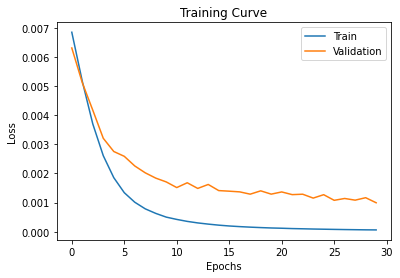

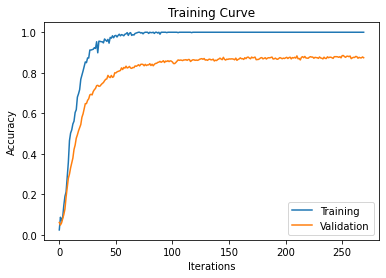

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8741168914579319
Final Training Loss: 6.0115386279196376e-05
Final Validation Loss: 0.000993452238617465
Total time:   630.35 s  Time per Epoch:  21.01 s 


In [ ]:
use_cuda = True

PrimaryModel_tune1 = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  PrimaryModel_tune1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_vgg(PrimaryModel_tune1, rec_train_data_vgg, rec_val_data_vgg, batch_size=512, num_epochs=30, learning_rate =1e-4, weight_decay=5e-4)

# Chosen primary model & validation accuracy

CUDA is available!  Training on GPU ...
Epoch 0 Finished.  Training Loss: 0.010505759390071034, Validation Loss: 0.0075538866221904755  | Training Accuracy: 0.92, Validation Accuracy: 0.6683417085427136  Time per Epoch:  1278.54 s 
Epoch 1 Finished.  Training Loss: 0.003658382365336785, Validation Loss: 0.004226265408630882  | Training Accuracy: 0.96, Validation Accuracy: 0.7650753768844221  Time per Epoch:  823.28 s 
Epoch 2 Finished.  Training Loss: 0.0015318450392582095, Validation Loss: 0.002954133553430438  | Training Accuracy: 0.96, Validation Accuracy: 0.8592964824120602  Time per Epoch:  692.44 s 
Epoch 3 Finished.  Training Loss: 0.0008705961495602074, Validation Loss: 0.0024584062796618256  | Training Accuracy: 1.0, Validation Accuracy: 0.867462311557789  Time per Epoch:  571.41 s 
Epoch 4 Finished.  Training Loss: 0.0005743180294162952, Validation Loss: 0.0020668068568089177  | Training Accuracy: 0.98, Validation Accuracy: 0.8793969849246231  Time per Epoch:  505.31 s 
Epoch

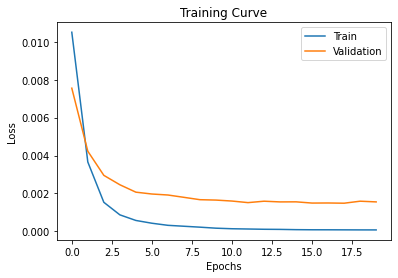

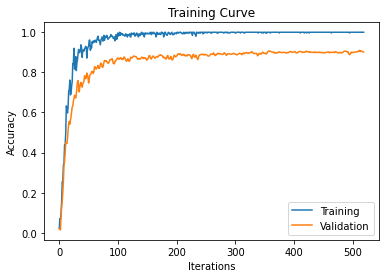

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9013819095477387
Final Training Loss: 7.503130809009935e-05
Final Validation Loss: 0.0015533015497827104
Total time:   3730.80 s  Time per Epoch:  186.54 s 


In [ ]:
use_cuda = True

PrimaryModel_tune2 = ANNClassifier(name="PrimaryModel_tune2")

if use_cuda and torch.cuda.is_available():
  PrimaryModel_tune2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


train_vgg(PrimaryModel_tune2, rec_train_data_vgg, rec_val_data_vgg, batch_size=256, num_epochs=20, learning_rate =1e-4, weight_decay=0.001)

# Chosen primary model & test accuracy

In [ ]:
use_cuda = True
rec_test_loader_vgg = torch.utils.data.DataLoader(rec_test_data_vgg, batch_size = 256, shuffle = True)

transfer_learning_trained_model2 = get_trained_model(ANNClassifier, "PrimaryModel_tune2", 256, 1e-4, 20)
primary_test_accurcy = get_accuracy_vgg(transfer_learning_trained_model2, rec_test_loader_vgg)
print("The final accuracy for primary model is {}".format(primary_test_accurcy))

The final accuracy for primary model is 0.8505555555555555


In [ ]:
def pred_vgg (model, data_loader):
    prediction_lst = []
    ground_lst = []

    model.eval()
    for imgs, labels in data_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        for pre in pred:
          prediction_lst.append(pre.item())
        for label in labels:
          ground_lst.append(label.item())

    return prediction_lst, ground_lst

In [ ]:
vgg_prediction_lst, vgg_ground_lst = pred_vgg(transfer_learning_trained_model2, rec_test_loader_vgg)

Confusion matrix for test data using primary model

Normalized confusion matrix


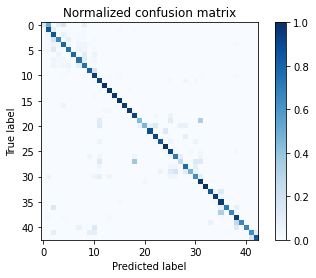

In [ ]:
plot_confusion_matrix(vgg_ground_lst, vgg_prediction_lst, classes=range(43), normalize = True, title='Normalized confusion matrix')

Confusion matrix for val data using primary model

In [ ]:
rec_val_loader_vgg = torch.utils.data.DataLoader(rec_val_data_vgg, batch_size = 256, shuffle = True)
vgg_prediction_val_lst, vgg_ground_val_lst =  pred_vgg(transfer_learning_trained_model2, rec_val_loader_vgg)

Normalized confusion matrix


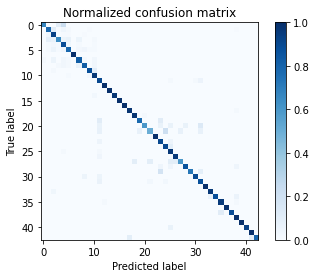

In [ ]:
plot_confusion_matrix(vgg_ground_val_lst, vgg_prediction_val_lst, classes=range(43), normalize = True, title='Normalized confusion matrix')

Get accuracy by class for primary model

In [ ]:
feature_lst = []
img_lst = []
gt_lst = []
for (img, label) in recognition_test_data:
    features = vgg19.features(img.unsqueeze(0))
    features_tensor = torch.from_numpy(features.detach().numpy())
    img_lst.append(img)
    feature_lst.append(features_tensor)
    gt_lst.append(label)

In [ ]:
def evaluate_vgg(model, feature, images, gt):
    prediction_vgg = []
    for i in range(len(feature)):
      model.eval()
      if torch.cuda.is_available():
        fte = feature[i].cuda()
      out_vgg = model(fte)
      pred_vgg = out_vgg.max(1, keepdim=True)[1]
      pred_vgg = int(pred_vgg[0].item())
      prediction_vgg.append(pred_vgg)
    
    incorrectly_classified_images = []
    incorrectly_classified_labels = []
    incorrectly_classified_predictions = []
    
    accuracy_by_class = np.zeros(43)
    for i in range(len(prediction_vgg)):
      if prediction_vgg[i] == gt[i]:
        accuracy_by_class[gt[i]] = accuracy_by_class[gt[i]]+1
      if prediction_vgg[i] != gt[i]:
        incorrectly_classified_images.append(images[i])
        incorrectly_classified_labels.append(gt[i])
        incorrectly_classified_predictions.append(prediction_vgg[i])

    
    for i in range(43):
      accuracy_by_class[i] = accuracy_by_class[i]/recognition_test_class_number[i]
    
    # print(classes_names[accuracy_by_class.tolist().index(min(accuracy_by_class))])
    # print(accuracy_by_class.tolist().index(min(accuracy_by_class)))
    # print(min(accuracy_by_class))

    accuracy_by_class_lst = accuracy_by_class.tolist()
    lst = []
    for accuracy in accuracy_by_class_lst:
      if accuracy < 0.5:
        lst.append(accuracy_by_class_lst.index(accuracy))

    return prediction_vgg

In [ ]:
def getAccuracyByClass(vgg_ground_lst, vgg_prediction_lst, recognition_class_number):
    incorrectly_classified_images = []
    incorrectly_classified_labels = []
    incorrectly_classified_predictions = []

    accuracy_by_class = np.zeros(43)
    for i in range(len(vgg_prediction_lst)):
      if vgg_prediction_lst[i] == vgg_ground_lst[i]:
        accuracy_by_class[vgg_ground_lst[i]] = accuracy_by_class[vgg_ground_lst[i]]+1
    accuracy_by_class = list(accuracy_by_class)
    for i in range(len(accuracy_by_class)):
      accuracy_by_class[i] = accuracy_by_class[i]/recognition_class_number[i]
    #   if vgg_prediction_lst[i] != vgg_ground_lst[i]:
    #     # incorrectly_classified_images.append(images[i])
    #     incorrectly_classified_labels.append(vgg_ground_lst[i])
    #     incorrectly_classified_predictions.append(prediction_vgg[i])
    # return incorrectly_classified_images, incorrectly_classified_labels, incorrectly_classified_predictions
    return accuracy_by_class

In [ ]:
accuracy_by_class

array([0.16666667, 0.85263158, 0.85294118, 0.66153846, 0.78651685,
       0.74157303, 0.78947368, 0.73846154, 0.75362319, 0.80952381,
       0.94117647, 0.92307692, 1.        , 0.99056604, 0.97674419,
       1.        , 0.95238095, 0.96363636, 0.92156863, 0.44444444,
       0.46666667, 0.875     , 0.90909091, 0.85      , 1.        ,
       0.92063492, 0.70833333, 0.25      , 0.77272727, 0.47058824,
       0.64      , 0.97222222, 1.        , 0.84375   , 0.96      ,
       0.96551724, 0.71428571, 0.66666667, 0.94117647, 0.66666667,
       0.66666667, 0.63636364, 0.84210526])

Max and min accuracy, and the respective classes

In [ ]:
print(max(accuracy_by_class), accuracy_by_class.index(max(accuracy_by_class)), classes_names[accuracy_by_class.index(max(accuracy_by_class))])
print(min(accuracy_by_class), accuracy_by_class.index(min(accuracy_by_class)), classes_names[accuracy_by_class.index(min(accuracy_by_class))])

1.0 12 priority road
0.16666666666666666 0 speed limit 20


Identify classes with 100% accuracy

In [ ]:
array_index = []
for i in range(len(array)):
  if array[i] == 1:
    array_index.append(i)

print(array_index)

[6, 12, 13, 15, 16, 22, 32, 36, 38, 39, 41]


Identify classes with >80% and <50% accuracy

In [ ]:
above = []
below = []
for accuracy in accuracy_by_class:
    if accuracy >= 0.8:
      above.append(accuracy_by_class.index(accuracy))

    if accuracy < 0.5:
      below.append(accuracy_by_class.index(accuracy))

print(above, below)
print(len(above), len(below))

[1, 2, 9, 10, 11, 12, 13, 14, 12, 16, 17, 18, 21, 22, 23, 12, 25, 31, 12, 33, 34, 35, 10, 42] [0, 19, 20, 27, 29]
24 5


#Visualise correct labels and incorrect predictions
Identify trends and similarities between commonly mislabeled images

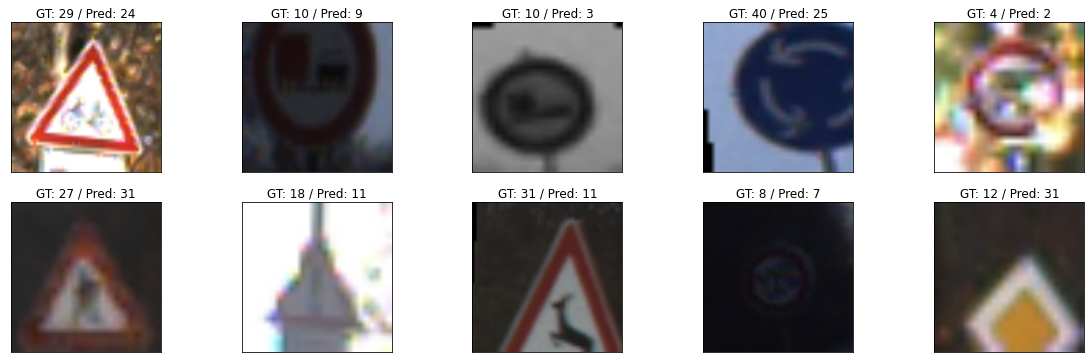

In [ ]:
fig = plt.figure(figsize=(20, 16))
for idx in np.arange(10):
    ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(incorrectly_classified_images[idx].cpu(), (1, 2, 0)))
    ax.set_title('GT: {} / Pred: {}'. format(int(incorrectly_classified_labels[idx]), int(incorrectly_classified_predictions[idx])))